# Exploratory analysis of the p-value dsitribution

## Introduction

To understand the solution designed to perform the analysis of p-value distributions, an exploratory analysis is hereafter shown. This analysis might help readers to understand the found distributions of reported p-values and the complexities in the analysis of factors which might influence the distribution of p-values.

The folder where the data is located is set as the working directory and the necessary libraries to perform the analysis are loaded.

In [2]:
setwd("C:\\Users\\dani5\\Documents\\Projects\\PhD\\p_value_dist\\data")

In [3]:
library(readr)
library(tidypvals)
library(ggplot2)
library(grid)
library(gridExtra)
library(dplyr)
library(caret)
library(reshape2)


Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice


## Loading of information

The 'tidypvals' package contains a repository of milions of p-values with additional information such as the year of publication, the Pubmed ID and/or DOI of the article or the scientific field whom the article belongs to.

https://github.com/jtleek/tidypvals

From this repository, we create a dataset of p-values which merges the p-values (and associated information) extracted from two studies:

head2015: http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002106

chavalarias2016: https://jamanetwork.com/journals/jama/fullarticle/10.1001/jama.2016.1952

We also rename some columns to ease later integration of information with the one coming from other datasets.

In [11]:
#Merge of both study datasets (taking into account that some p-values are present in both datasets)
aj1 = anti_join(head2015,chavalarias2016)%>%mutate(dataset="head2015")
aj2 = anti_join(chavalarias2016,head2015)%>%mutate(dataset="chavalarias2016")
sj1 = semi_join(head2015,chavalarias2016)%>%mutate(dataset="both")

allp = rbind(aj1,aj2,sj1) %>% 
#Renaming of columns to ease later integration of information
mutate(EntrezUID=as.character(pmid),DOI=as.character(doi),dataset=as.factor(dataset)) %>%
#Selection of relevant columns
select(pvalue,EntrezUID,DOI,year,dataset)%>%
#Filtering of incomplete data of identifiers (there are some p-vlaues without article identifier)
na.omit(.)

Joining, by = c("pvalue", "year", "journal", "field", "abstract", "operator", "doi", "pmid")
Joining, by = c("pvalue", "year", "journal", "field", "abstract", "operator", "doi", "pmid")
Joining, by = c("pvalue", "year", "journal", "field", "abstract", "operator", "doi", "pmid")


In [12]:
rm(aj1)
rm(aj2)
rm(sj1)

The final p-values dataset ('allp') contains millions of p-values of multiple fields. However, we want to restrict the analysis of relevant factors in the distribution of p-values to the analysis of -omics fields in order to ensure accurate interpretability of the results.

Therefore, the articles (and article identifiers) from four different -omics fields (genomics, transcriptomics, proteomics, metabolomics) have been found with search engines like Pubmed and Scopus. The article identifiers have been then used to filter the p-values only related to the study of one of the -omics fields ('allp_reduced').

In [ ]:
#Loading of articles related to one of the -omics fields studied.

omics_information=rbind(
    read_csv("genomics.csv")%>%select(EntrezUID)%>%mutate(Field=as.factor("Genomics")),
    read_csv("transcriptomics.csv")%>%select(EntrezUID)%>%mutate(Field=as.factor("Transcriptomics")),
    read_csv("proteomics.csv")%>%select(EntrezUID)%>%mutate(Field=as.factor("Proteomics")),
    read_csv('metabolomics_scopus_data.csv')%>%select(PubMed.ID)%>%rename("EntrezUID" = "PubMed.ID")%>%
    mutate(Field=as.factor("Metabolomics")))

In [14]:
#Filtering of the p-value dataset to contain only articles realted to the -omics fields.

allp_reduced=allp %>%
# filter(EntrezUID %in% omics_information$EntrezUID) %>% 
inner_join(.,omics_information,by="EntrezUID")

This is the summary of the final dataset of p-values obtained

In [15]:
summary(allp_reduced)

     pvalue          EntrezUID             DOI                 year     
 Min.   : 0.00000   Length:138889      Length:138889      Min.   :2001  
 1st Qu.: 0.00100   Class :character   Class :character   1st Qu.:2011  
 Median : 0.01900   Mode  :character   Mode  :character   Median :2012  
 Mean   : 0.06052                                         Mean   :2012  
 3rd Qu.: 0.05000                                         3rd Qu.:2014  
 Max.   : 9.99989                                         Max.   :2015  
            dataset                  Field      
 both           :49889   Genomics       :77287  
 chavalarias2016:81199   Transcriptomics:38174  
 head2015       : 7801   Proteomics     :17071  
                         Metabolomics   : 6357  
                                                
                                                

An histogram of the numeric columns in the dataset shows this shape:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


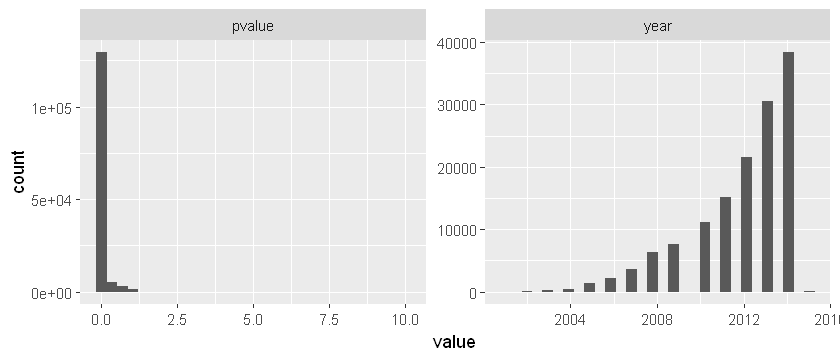

In [16]:
options(repr.plot.width=7, repr.plot.height=3)
allp_reduced %>%
  purrr::keep(is.numeric) %>%
  tidyr::gather() %>%
  ggplot(aes(value)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram()

We can see that the distribution of articles by year of publication is right tailed and that the distribution of p-values is extremely left-tailed. This is caused by the publication bias i.e. the tendency to report only p-values lower than 0.05.

The best kind of visualization to analyze the distribution of p-values in the dataset is with a density plot with a logarithmic x-axis:

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 18874 rows containing non-finite values (stat_density)."

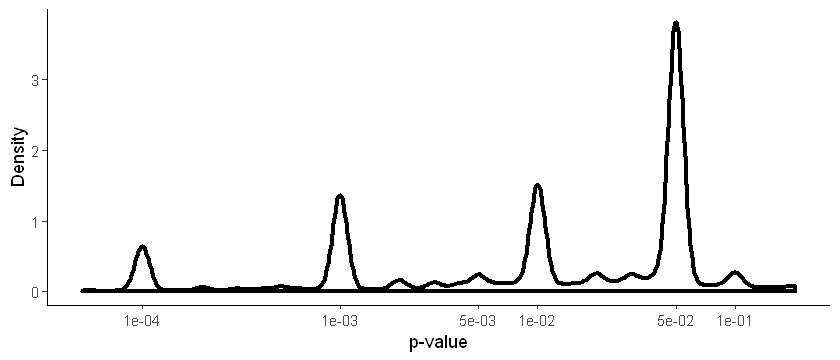

In [25]:
options(repr.plot.width=7, repr.plot.height=3)

allp_reduced %>%
ggplot(aes(x=pvalue)) +
geom_density(alpha=0.1,size=1.2,adjust = 1/2) +
scale_x_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_color_brewer(palette = "Set1") +
theme_bw() +
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
labs(x = "p-value",y='Density')

Several clear modes of density of reported p-values can be observed in the p-value distribution. The most important ones are 0.0001, 0.001, 0.01, 0.05.

These modes are caused by the tendency to round the p-values to traditional thresholds depending on the "intensity" of the significant result. For example, a p-value of 0.008 would be probably rounded to the nearest higher mode (<=0.01). A p-value of 0.02 would be rounded to the nearest higher mode (<=0.05).

In this study, according to this analysis of the p-value dsitribution, we make the assumption that the p-values rounded to one of those modes can actually be between this mode and the next lower one (i.e between 0.01 and 0.05). Therefore, when trying to perform studies like the one performed for this dataset, the binning behavior when reporting p-values needs to be reproduced with a binning of p-values in the dataset in order to accurately reflect the data present (i.e. (0,0.0001], (0.0001,0.001],(0.001,0.01],(0.01,0.05]). 

## Example of the influence of interactions between covariates

With the obtained p-value dataset, we can start implementing analyses of the interaction between the analyzed features and the distribution of p-values.

A first analysis can be related to the influence of the year of publication with the distribtuion of p-values:

1. We cap the year of publication to between 2009 and 2014 to ease visualization.
2. We transform the year of publication into a categorical variable.
3. We correct the class imbalance in the categorical variable (by downsampling) to ensure the density plots can be accurately compared.

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 9553 rows containing non-finite values (stat_density)."

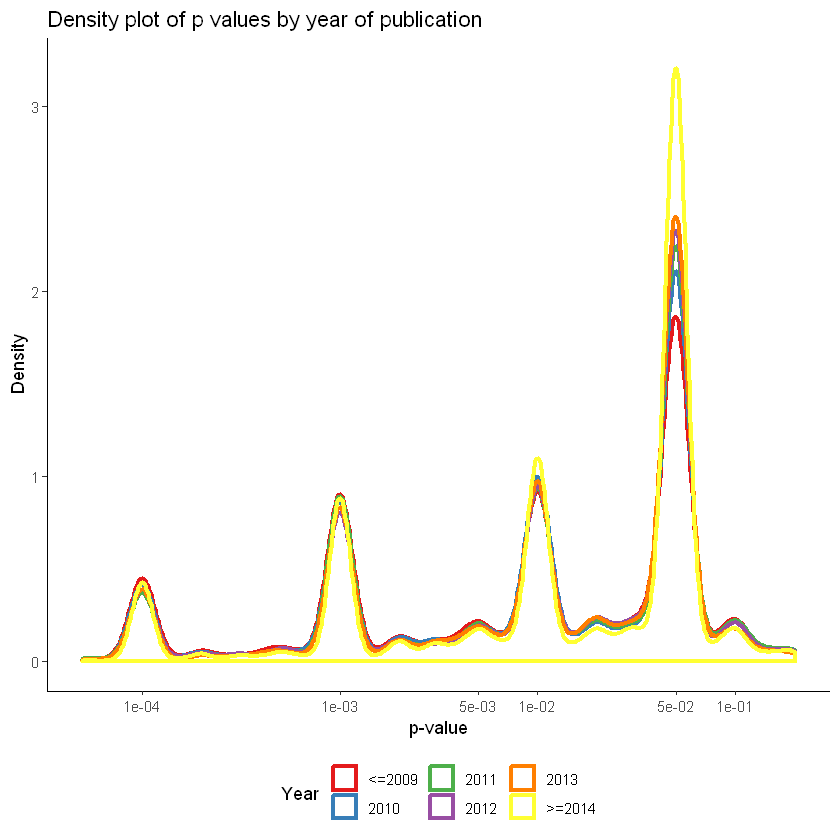

In [26]:
options(repr.plot.width=7, repr.plot.height=7)

data=allp_reduced %>%
mutate(year=cut(year,c(0,2009.5,2010.5,2011.5,2012.5,2013.5,2020),c("<=2009","2010","2011","2012","2013",">=2014")))


data=downSample(data,data$year,list=T)$x

ggplot(data=data, aes(x=pvalue, colour=year))+
geom_density(alpha=0.1,size=1.2,adjust = 1/2) +
scale_x_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_color_brewer(palette = "Set1") + 
theme_bw() + 
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
  labs(x = "p-value",y='Density',title="Density plot of p values by year of publication",colour='Year')

According to the generated figure, we observe that, in theory, there is a clear correlation between the year of publication and the distribution of p-values. The articles from 2014 or later (yellow trace) have clearly the highest mode in the <=0.05 mode, while the articles from 2009 or before (red trace) have the lowest mode.

We might start inferring from this figure possible attractive hypotheses about why recent articles have higher proportion of <=0.05 p-values  (e.g. higher pressure to publish, progresively more complex hypotheses tested with lower effect size).

However, the actual cause behind the above shown figures might be the different data properties of the two p-value datasets used in this study. These two daasets were collected in different years. The 'chavalarias2016' dataset (blue trace) has a much higher proportion of p-values from 2014 or later:

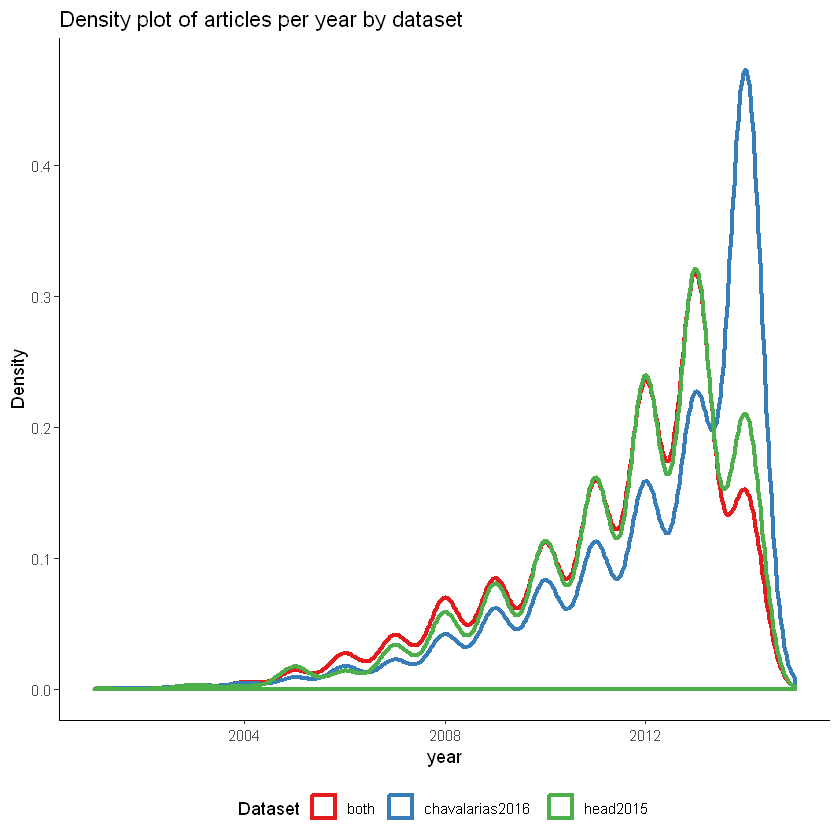

In [27]:
set.seed(1);data=downSample(allp_reduced,allp_reduced$dataset,list=T)$x

ggplot(data=data, aes(x=year, colour=dataset))+
  geom_density(alpha=0.3,size=1.2) +
# scale_x_log10() +
scale_color_brewer(palette = "Set1") + 
theme_bw() + 
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
  labs(x = "year",y='Density',title="Density plot of articles per year by dataset",colour='Dataset')

The 'chavalarias2016' dataset has also a higher quantity of p-values between 0.01 and 0.05 (blue trace):

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 2991 rows containing non-finite values (stat_density)."

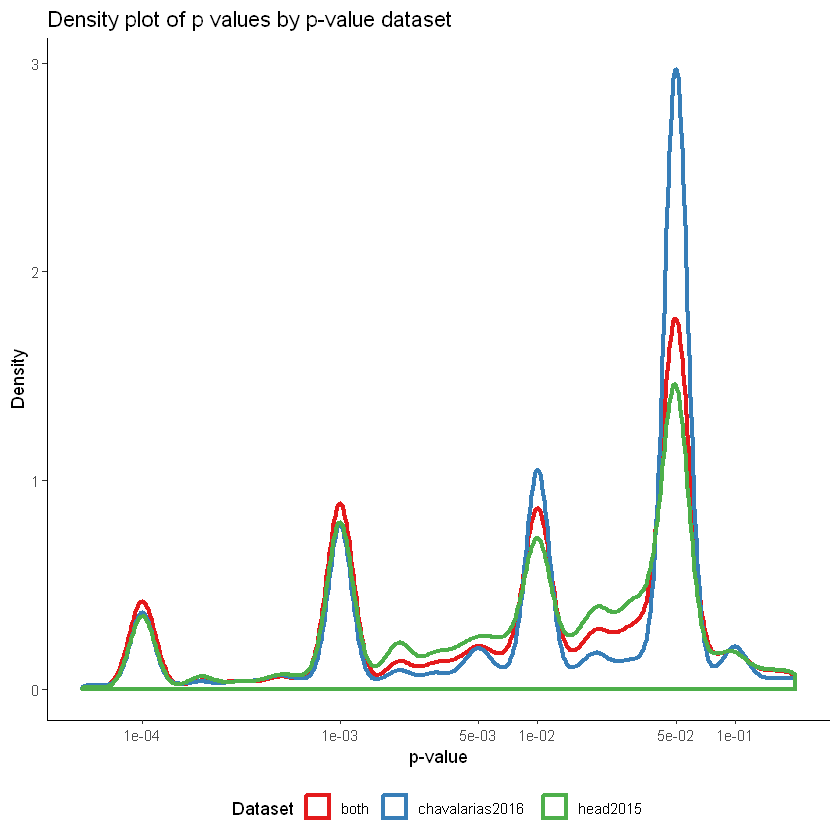

In [28]:
options(repr.plot.width=7, repr.plot.height=7)

data=downSample(allp_reduced,allp_reduced$dataset,list=T)$x

ggplot(data=data, aes(x=pvalue, colour=dataset))+
geom_density(alpha=0.1,size=1.2,adjust = 1/2) +
scale_x_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_color_brewer(palette = "Set1") + 
theme_bw() + 
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
  labs(x = "p-value",y='Density',title="Density plot of p values by p-value dataset",colour='Dataset')

Therefore, the effect of the year of publication in the distribution of p-values might be caused by the much higher presence of articles from the 'chavalarias2016' dataset in the output of articles from 2014. Actually, the results of the training of a model predicting p-values ('pvalue_prediction_model_training.ipynb') suggests that the actual effect of the year of publciation in the distribution of p-valeus would be the opposite one.

This kind of interaction between covariates is constant and high between the several factors analyzed in the dataset and greatly challenges the possible implementation of statistical modelling approaches which try to model the several interactions present in the dataset. Any kind of statistical model and inference about the influecnce of the factors in the output of p-values should be very careful and open about the process performed.

Because of this, our study consists of a machine learning based implementation of the prediction of p-values according to the factors studied (with later interpretability analyses of how each factor influences the distribution of p-values). ML prediction models are not focused on inference but on the prediction performance; therefore, they are not strict in the need of assumptions or pre-specification of interactions.

The demonstration that the analyzed features can help improve the prediction of p-values would be a demonstration of the need to take into account these factors when analyzing the possibile quality of a study. In aiddition, the analysis of the effect of each variable to the prediction will help suggest possible measures to improvements the requirements to publish a study (e.g., -omics fields which show a higher output of low p-values should have higher requirements to publish a study).

This ML-based study is shown in the 'pvalue_prediction_model_training.ipynb' notebook. The rest of this notebook shows exploratory analyses about how each factor might influence the distribution of p-values in order to get helpful insights which helped make choices to train the best possible prediction model.

## Exploratory analysis of the importance of the -omics field 

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 2767 rows containing non-finite values (stat_density)."

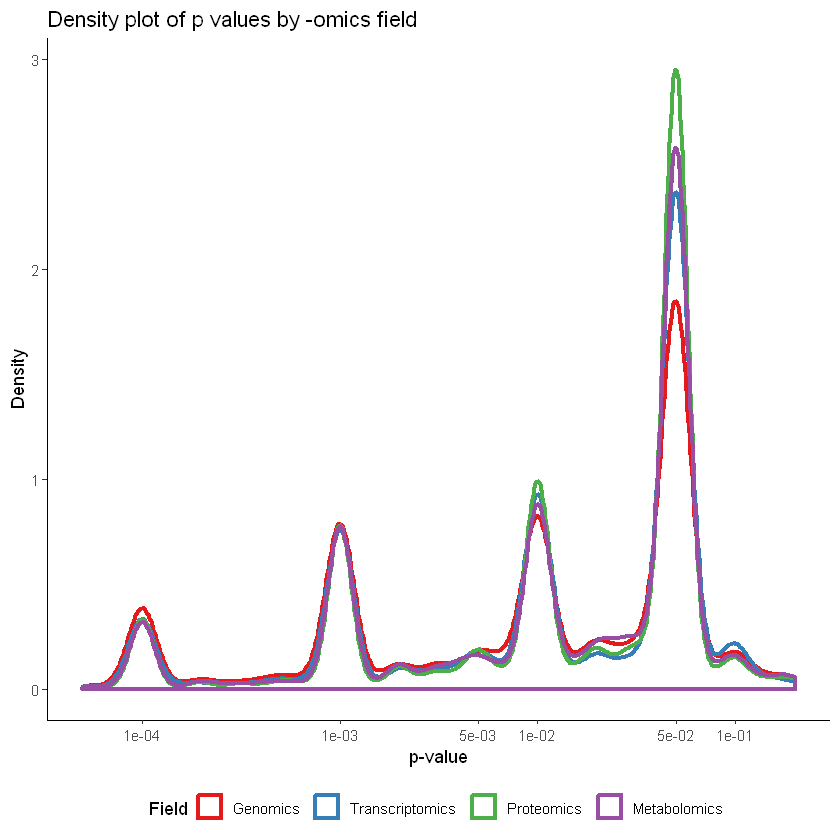

In [5]:
options(repr.plot.width=7, repr.plot.height=7)

data=downSample(allp_reduced,allp_reduced$Field,list=T)$x

ggplot(data=data, aes(x=pvalue, colour=Field))+
geom_density(alpha=0.1,size=1.2,adjust = 1/2) +
scale_x_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_color_brewer(palette = "Set1") + 
theme_bw() + 
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
  labs(x = "p-value",y='Density',title="Density plot of p values by -omics field",colour='Field')

It should be expected that the higher the influence of the phenotype in the field studied, the higher the variance in the effect size and the higher the possibility of reporting "high" p-values (i.e., between 0.01 and 0.05). In concordance with this intuition, the highest <=0.05 mode of p-values is found with -omics fields such as proteomics or metabolomics, and the lowest mode is found in the p-values of the genomics field. The <=0.01 mode shows a similar pattern.

In addition, the higher variance in the dataset might oblige to perform multiple pre-processing steps to the dataset which give room to maneuver to find significant p-values accidentally. 

However, it should not be discarded that the journals of certain -omics fields have more tendency to round p-values than the journals in other fields.

## Exploratory analysis of relationship between citation count and distribution of p-values

The citation count of an article is the best parameter present in scientific research to infer the possible quality of an article without reading it.

If the distribution of p-values is a good indicator of the quality of research, there should be a relationship between the citation count and the dsitribution of p-values.

To confirm this hypothesis, the citation count of the articles from the p-value dataset was when possible extracted and added to the p-value dataset. Next, the citation count was binned into four quartiles to allow visualization of p-value dsitributions. The citation binning was grouped by the -omics field, as the citation count is dependent on the number of research groups and studies performed in each -omic field. 

In [ ]:
genomics_citation_data = merge(
    rbind(
        read_csv("genomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("genomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("genomics_scopus_1.csv"),
        read_csv("genomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Genomics",Citation=cut(as.numeric(Citation), 
    quantile(Citation,seq(0,1,0.25)), 
    labels = c('4th quartile','3rd quartile','2nd quartile','1st quartile'),
    include.lowest = T))

transcriptomics_citation_data = merge(
    rbind(
        read_csv("transcriptomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("transcriptomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("transcriptomics_scopus_1.csv"),
        read_csv("transcriptomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Transcriptomics",Citation=cut(as.numeric(Citation), 
    quantile(Citation,seq(0,1,0.25)), 
    labels = c('4th quartile','3rd quartile','2nd quartile','1st quartile'),
    include.lowest = T))

proteomics_citation_data = merge(
    rbind(
        read_csv("proteomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("proteomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("proteomics_scopus_1.csv"),
        read_csv("proteomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Proteomics",Citation=cut(as.numeric(Citation), 
    quantile(Citation,seq(0,1,0.25)), 
    labels = c('4th quartile','3rd quartile','2nd quartile','1st quartile'),
    include.lowest = T))

metabolomics_citation_data = merge(
        read_csv("metabolomics_citation.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        %>% rename("Title" = "Document Title"),
        read_csv("metabolomics_scopus.csv"),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Metabolomics",Citation=cut(as.numeric(Citation), 
    quantile(Citation,seq(0,1,0.25)), 
    labels = c('4th quartile','3rd quartile','2nd quartile','1st quartile'),
    include.lowest = T))

In [48]:
citation_information=rbind(genomics_citation_data,
              transcriptomics_citation_data,
              proteomics_citation_data,
              metabolomics_citation_data)

In [49]:
data=allp_reduced %>%
left_join(citation_information,by="DOI")%>%
mutate(Field=Field.x)%>%
filter(!is.na(Citation))

data=downSample(data,data$Citation,list=T)$x

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 8524 rows containing non-finite values (stat_density)."

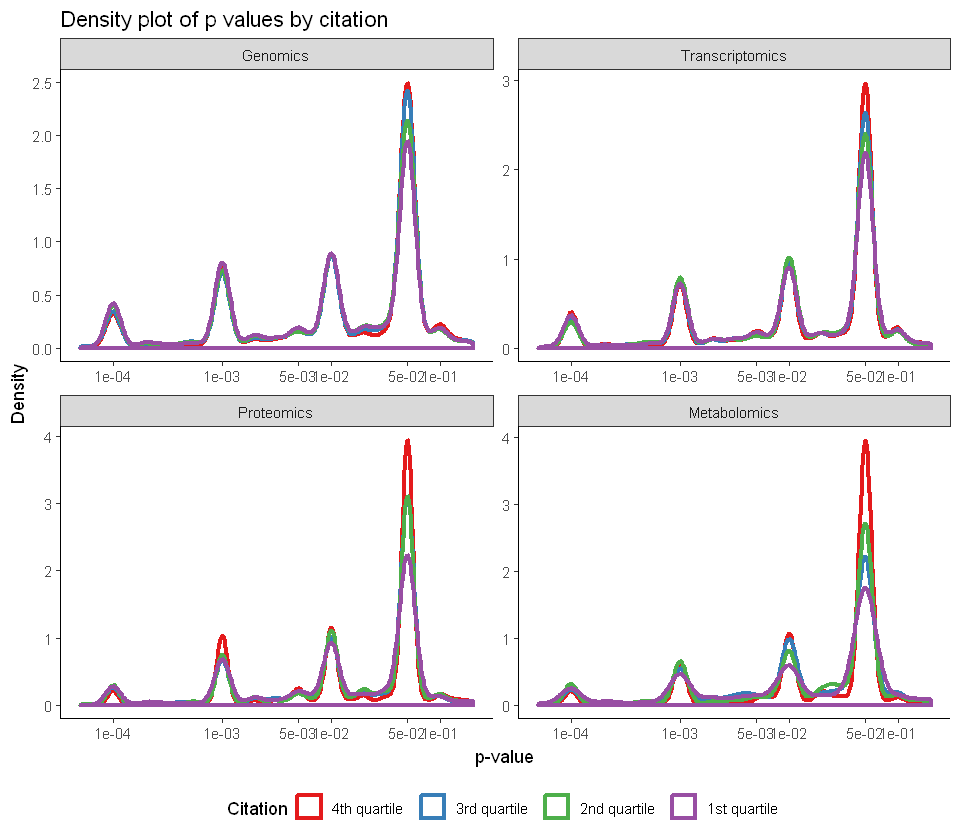

In [51]:
options(repr.plot.width=8, repr.plot.height=7)

ggplot(data=data, aes(x=pvalue, colour=Citation))+
  facet_wrap(~ Field, scales = "free") +
geom_density(alpha=0.1,size=1.2,adjust = 1/2) +
scale_x_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_color_brewer(palette = "Set1") +
theme_bw() +
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
labs(x = "p-value",y='Density',colour='Citation',title="Density plot of p values by citation")


In all -omics fields, it can be confirmed that there is a relationship between the dsitribution of p-values and the citation count. The articles in the first quartile of citation count (purple trace) show the lowest reporting of <=0.05 p-values,the articles in the fourth quartile (red trace) show the highest reporting of <=0.05 p-values.

Interestingly, the starkest differences between quartiles are present in the proteomics and metabolomics fields, in consonance with the importance of the -omic field observed in the previous section.

## Exploratory analysis of importance of country affiliation

The information about the country of affiliation analyzed is loaded and then merged with the p-value dataset, before downsampling and plotting the figure.

In [ ]:
country_proteomics=rbind(
    read_csv("germany_proteomics.csv")%>%mutate(Country="Germany"),
    read_csv("china_proteomics.csv")%>%mutate(Country="China"),
    read_csv("us_proteomics.csv")%>%mutate(Country="US"),
    read_csv("spain_proteomics.csv")%>%mutate(Country="Spain"),
    read_csv("uk_proteomics.csv")%>%mutate(Country="UK"),
    read_csv("france_proteomics.csv")%>%mutate(Country="France"),
    read_csv("italy_proteomics.csv")%>%mutate(Country="Italy"),
    read_csv("japan_proteomics.csv")%>%mutate(Country="Japan"),
    read_csv("netherlands_proteomics.csv")%>%mutate(Country="Netherlands"),
    read_csv("canada_proteomics.csv")%>%mutate(Country="Canada")
) %>% select(EntrezUID,Country) %>% mutate(Field=as.factor("Proteomics"),Country=as.factor(Country))

country_genomics=rbind(
    read_csv("germany_genomics.csv")%>%mutate(Country="Germany"),
    read_csv("china_genomics.csv")%>%mutate(Country="China"),
    read_csv("us_genomics.csv")%>%mutate(Country="US"),
    read_csv("spain_genomics.csv")%>%mutate(Country="Spain"),
    read_csv("uk_genomics.csv")%>%mutate(Country="UK"),
    read_csv("france_genomics.csv")%>%mutate(Country="France"),
    read_csv("italy_genomics.csv")%>%mutate(Country="Italy"),
    read_csv("japan_genomics.csv")%>%mutate(Country="Japan"),
    read_csv("netherlands_genomics.csv")%>%mutate(Country="Netherlands"),
    read_csv("canada_genomics.csv")%>%mutate(Country="Canada")
) %>% select(EntrezUID,Country) %>% mutate(Field=as.factor("Genomics"),Country=as.factor(Country))

country_transcriptomics=rbind(
    read_csv("germany_transcriptomics.csv")%>%mutate(Country="Germany"),
    read_csv("china_transcriptomics.csv")%>%mutate(Country="China"),
    read_csv("us_transcriptomics.csv")%>%mutate(Country="US"),
    read_csv("spain_transcriptomics.csv")%>%mutate(Country="Spain"),
    read_csv("uk_transcriptomics.csv")%>%mutate(Country="UK"),
    read_csv("france_transcriptomics.csv")%>%mutate(Country="France"),
    read_csv("italy_transcriptomics.csv")%>%mutate(Country="Italy"),
    read_csv("japan_transcriptomics.csv")%>%mutate(Country="Japan"),
    read_csv("netherlands_transcriptomics.csv")%>%mutate(Country="Netherlands"),
    read_csv("canada_transcriptomics.csv")%>%mutate(Country="Canada")
) %>% select(EntrezUID,Country) %>% mutate(Field=as.factor("Transcriptomics"),Country=as.factor(Country))

metabolomics_scopus_data=read_csv('metabolomics_scopus_data.csv')

country_metabolomics=rbind(
    metabolomics_scopus_data[grep('Germany',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Germany"),
    metabolomics_scopus_data[grep('China',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="China"),
    metabolomics_scopus_data[grep('United States',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="US"),
    metabolomics_scopus_data[grep('Spain',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Spain"),
    metabolomics_scopus_data[grep('United Kingdom',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="UK"),
    metabolomics_scopus_data[grep('France',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="France"),
    metabolomics_scopus_data[grep('Italy',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Italy"),
    metabolomics_scopus_data[grep('Japan',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Japan"),
    metabolomics_scopus_data[grep('Netherlands',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Netherlands"),
    metabolomics_scopus_data[grep('Canada',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Canada")
) %>% mutate(Field=as.factor("Metabolomics"),EntrezUID=as.character(PubMed.ID),Country=as.factor(Country)) %>% 
select(EntrezUID,Country,Field) 



In [36]:
country_information=rbind(country_genomics,
              country_transcriptomics,
              country_proteomics,
              country_metabolomics) %>% select(-Field)

In [37]:
data=allp_reduced %>%
left_join(country_information,by="EntrezUID") %>%
filter(!is.na(Country))

data=downSample(data,data$Country,list=T)$x

data$EU="EU Countries"
data$EU[data$Country %in% c("Canada","China","Japan","US")]="Not EU countries"
data$EU=as.factor(data$EU)

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 6515 rows containing non-finite values (stat_density)."

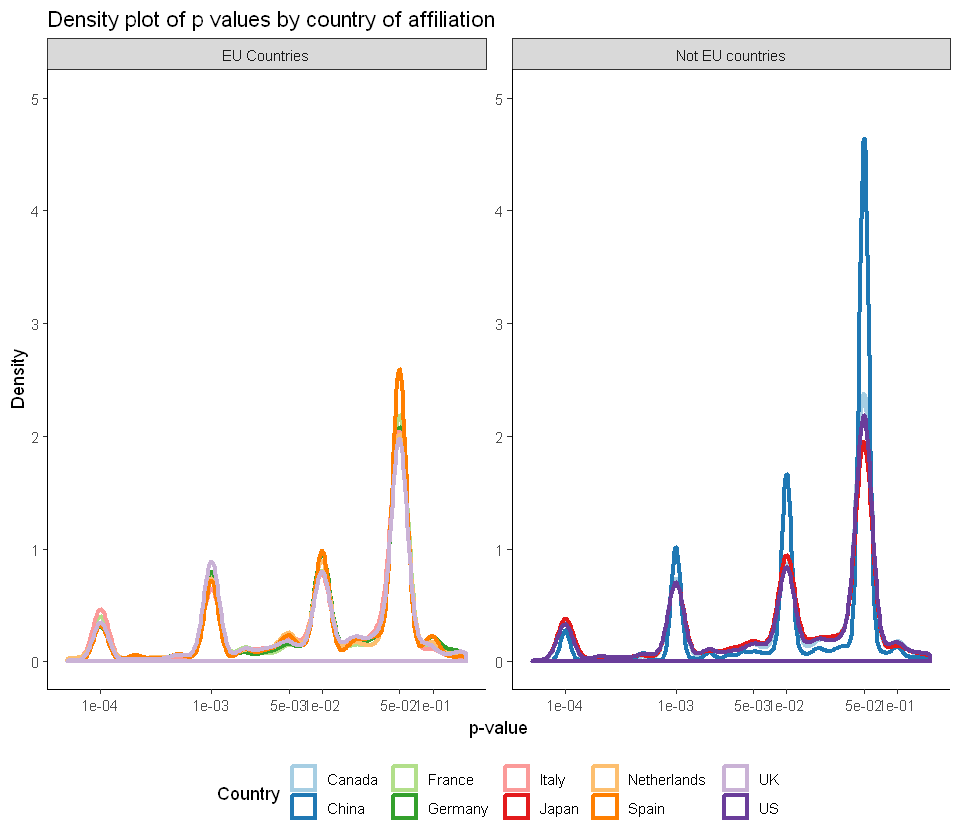

In [41]:
options(repr.plot.width=8, repr.plot.height=7)

ggplot(data=data, aes(x=pvalue, colour=Country))+
  facet_wrap(~ EU, scales = "free") +
geom_density(alpha=0.1,size=1.2,adjust = 1/2) +
scale_x_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_y_continuous(limits=c(0,5))+
scale_color_brewer(palette = "Paired") +
theme_bw() +
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
labs(x = "p-value",y='Density',colour='Country',title="Density plot of p values by country of affiliation")

Most countries show a similar distribution of p-values. Regarding the mode of <=0.05 p-values, the interesting patterns are the low modes of UK (violet, left figure) and Japan (dark red, right figure) articles, the high mode of p-values of articles with Spanish affiliation (dark orange, left figure) and the very different patterns of articles with China as country affiliation (dark blue, right figure).

A very important confounder in this analysis is the effect of the impact of the research performed. Countries which still tend to develop research of lower impact (because of recent scientific emergence) might present studies with lower sample sizes and hypotheses of lower effect size. These challenges might mediate the high generation of (0.01-0.05] p-values.

## Exploratory analysis of importance of species/kingdom studied

The information about the species/kingdom analyzed is loaded and then merged with the p-value dataset, before downsampling and plotting the figure.

In [ ]:
species_proteomics=rbind(
    read_csv("human_proteomics.csv")%>%mutate(Species="Human"),
    read_csv("animal_proteomics.csv")%>%mutate(Species="Animal"),
    read_csv("plant_proteomics.csv")%>%mutate(Species="Plant"),
    read_csv("bacteria_proteomics.csv")%>%mutate(Species="Bacteria")
) %>% select(EntrezUID,Species) %>% mutate(Field=as.factor("Proteomics"),Species=as.factor(Species))

species_genomics=rbind(
    read_csv("human_genomics.csv")%>%mutate(Species="Human"),
    read_csv("animal_genomics.csv")%>%mutate(Species="Animal"),
    read_csv("plant_genomics.csv")%>%mutate(Species="Plant"),
    read_csv("bacteria_genomics.csv")%>%mutate(Species="Bacteria")
) %>% select(EntrezUID,Species) %>% mutate(Field=as.factor("Genomics"),Species=as.factor(Species))


species_transcriptomics=rbind(
    read_csv("human_transcriptomics.csv")%>%mutate(Species="Human"),
    read_csv("animal_transcriptomics.csv")%>%mutate(Species="Animal"),
    read_csv("plant_transcriptomics.csv")%>%mutate(Species="Plant"),
    read_csv("bacteria_transcriptomics.csv")%>%mutate(Species="Bacteria")
) %>% select(EntrezUID,Species) %>% mutate(Field=as.factor("Transcriptomics"),Species=as.factor(Species))

species_metabolomics=rbind(
    metabolomics_scopus_data[grep('human',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Human"),
    metabolomics_scopus_data[grep('animal',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Animal"),
    metabolomics_scopus_data[grep('plant',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Plant"),
    metabolomics_scopus_data[grep('bacteria',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Bacteria")
) %>% mutate(Field=as.factor("Metabolomics"),EntrezUID=as.character(PubMed.ID),Species=as.factor(Species)) %>% 
select(EntrezUID,Species,Field) 


In [43]:
species_information=rbind(species_genomics,
              species_transcriptomics,
              species_proteomics,
              species_metabolomics) %>% select(-Field)

In [44]:
data=allp_reduced %>%
left_join(species_information,by="EntrezUID")%>%
filter(!is.na(Species))

data=downSample(data,data$Species,list=T)$x

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 10995 rows containing non-finite values (stat_density)."

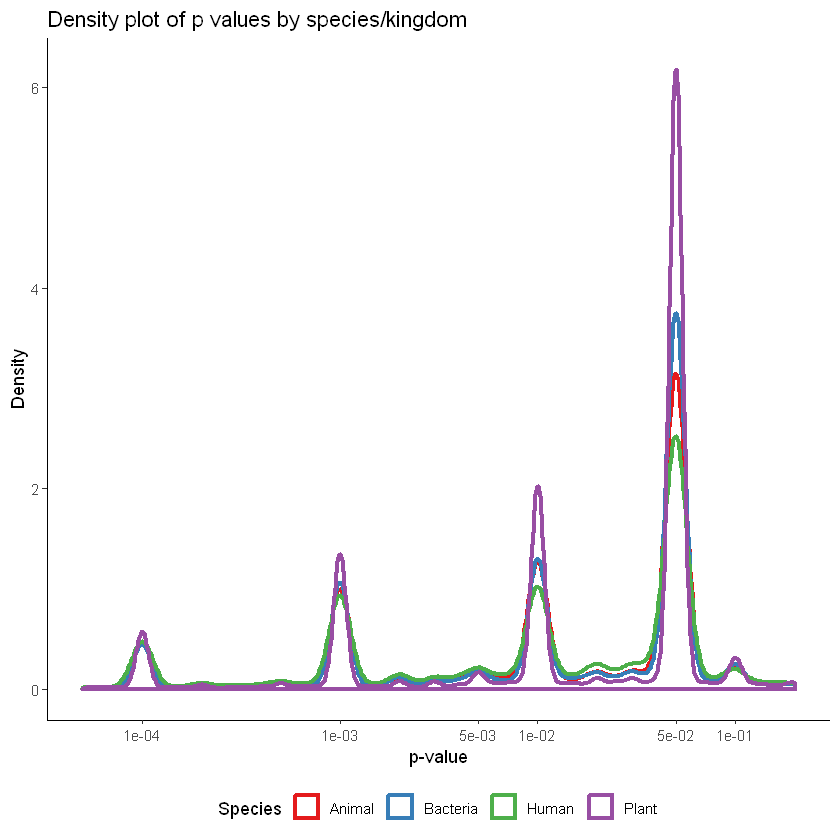

In [46]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(data=data, aes(x=pvalue, colour=Species))+
geom_density(alpha=0.1,size=1.2,adjust = 1/2) +
scale_x_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_color_brewer(palette = "Set1") +
theme_bw() +
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
labs(x = "p-value",y='Density',colour='Species',title="Density plot of p values by species/kingdom")


Articles whose species to study is humans show the lowest mode of <=0.01 and <=0.05 p-values. In contrast, articles which study plants show the highest mode of <=0.01 and <=0.05 p-values.

An intuitive explanation to this result is the effect of the standardization of protocols: species which have been more studied (humans, certain animals) have developed more strict protocols which ensure lower varaiiblity in the preparation of samples or in the pre-processing of the obtained data.

In [4]:
save.image('exploratory_analysis.RData')

Parsed with column specification:
cols(
  `Publication Year` = col_double(),
  `Document Title` = col_character(),
  Authors = col_character(),
  ISSN = col_character(),
  `Journal Title` = col_character(),
  Volume = col_character(),
  Issue = col_character(),
  `17` = col_double(),
  `30` = col_double(),
  `2` = col_double(),
  `10` = col_double(),
  `39` = col_double(),
  `3585` = col_double(),
  `24296` = col_double(),
  `57856` = col_double(),
  `94629` = col_double(),
  `180447` = col_double(),
  `324693` = col_double(),
  `505157` = col_double()
)
Parsed with column specification:
cols(
  `Publication Year` = col_double(),
  `Document Title` = col_character(),
  Authors = col_character(),
  ISSN = col_character(),
  `Journal Title` = col_character(),
  Volume = col_character(),
  Issue = col_character(),
  `78` = col_double(),
  `4999` = col_double(),
  `23787` = col_double(),
  `51563` = col_double(),
  `77816` = col_double(),
  `106674` = col_double(),
  `131524` = col_double(

Warning message:
"77 parsing failures.
 row        col           expected    actual                      file
1228 Page count 1/0/T/F/TRUE/FALSE B21       'proteomics_scopus_2.csv'
1707 Page count 1/0/T/F/TRUE/FALSE Unit 24.3 'proteomics_scopus_2.csv'
1780 Page count 1/0/T/F/TRUE/FALSE S1        'proteomics_scopus_2.csv'
1905 Page count 1/0/T/F/TRUE/FALSE Unit 13.5 'proteomics_scopus_2.csv'
2149 Page count 1/0/T/F/TRUE/FALSE e83       'proteomics_scopus_2.csv'
.... .......... .................. ......... .........................
See problems(...) for more details.
"Parsed with column specification:
cols(
  `Publication Year` = col_double(),
  `Document Title` = col_character(),
  Authors = col_character(),
  ISSN = col_character(),
  `Journal Title` = col_character(),
  Volume = col_character(),
  Issue = col_character(),
  `13` = col_double(),
  `417` = col_double(),
  `2389` = col_double(),
  `5837` = col_double(),
  `10328` = col_double(),
  `16461` = col_double(),
  `24152` = col_

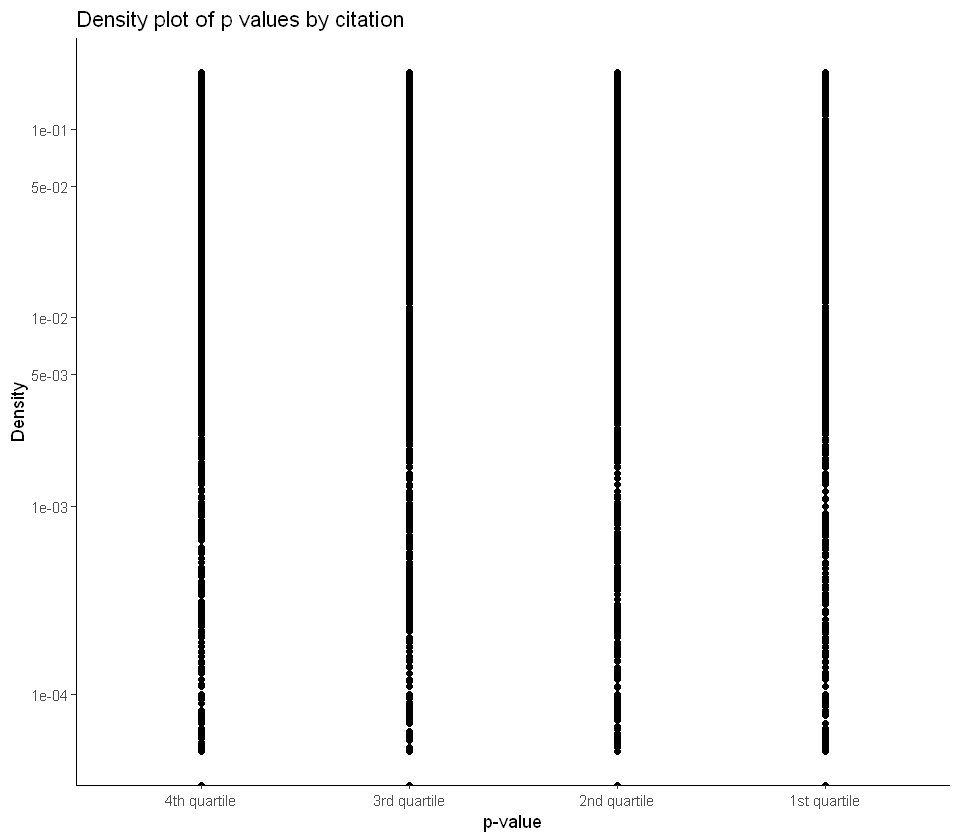

In [5]:
load('exploratory_analysis.RData')
genomics_citation_data = merge(
    rbind(
        read_csv("genomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("genomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("genomics_scopus_1.csv"),
        read_csv("genomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Genomics",Citation=as.numeric(Citation))

transcriptomics_citation_data = merge(
    rbind(
        read_csv("transcriptomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("transcriptomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("transcriptomics_scopus_1.csv"),
        read_csv("transcriptomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Transcriptomics",Citation=as.numeric(Citation))


proteomics_citation_data = merge(
    rbind(
        read_csv("proteomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("proteomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("proteomics_scopus_1.csv"),
        read_csv("proteomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Proteomics",Citation=as.numeric(Citation))

metabolomics_citation_data = merge(
        read_csv("metabolomics_citation.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        %>% rename("Title" = "Document Title"),
        read_csv("metabolomics_scopus.csv"),
    by='Title')  %>% 
select(DOI,Citation) %>% 
mutate(Field="Metabolomics",Citation=as.numeric(Citation))


In [9]:
citation_information=rbind(genomics_citation_data,
              transcriptomics_citation_data,
              proteomics_citation_data,
              metabolomics_citation_data)

Warning message:
"Transformation introduced infinite values in continuous y-axis"Warning message:
"Removed 12998 rows containing missing values (geom_point)."

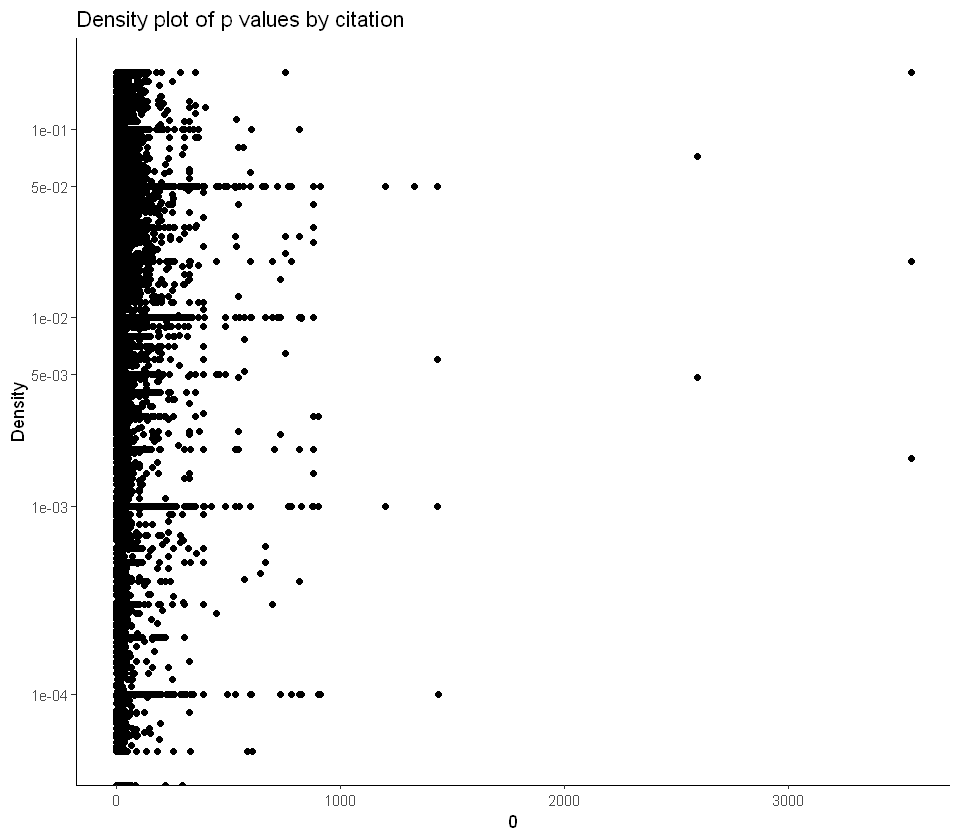

In [11]:
data=allp_reduced %>%
left_join(citation_information,by="DOI")%>%
mutate(Field=Field.x)%>%
filter(!is.na(Citation))

# data=downSample(data,data$Citation,list=T)$x

options(repr.plot.width=8, repr.plot.height=7)

ggplot(data=data, aes(y=pvalue, x=Citation))+
#   facet_wrap(~ Field, scales = "free") +
geom_point() +
scale_y_log10(breaks=c(1e-6,1e-5,1e-4,0.001,0.005,0.01,0.05,0.1,1),limits=c(5e-5,0.2))+
scale_x_continuous(c(0,50))+

# scale_color_brewer(palette = "Set1") +
theme_bw() +
theme(legend.position="bottom",panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
labs(x = "p-value",y='Density',colour='Citation',title="Density plot of p values by citation")